In [ ]:
#========================================================================
#
# Name: 01 Blank.ipynb
#
# Date: 29/12/2024
#
# Author: MT
# 
# Description: Here
# https://www.kaggle.com/datasets/sezermehmetemre/london-property-listings-dataset
#
# Steps:
# Step 0: Imports and Locations
#
# Notes: 
#
#========================================================================

In [1]:
#========================================================================
# Step 0: Imports and Locations

# Imports
import pandas as pd
import numpy as np
import copy
pd.set_option('display.max_columns', 10000) # 10000 columns
pd.set_option('display.max_rows', 10000) # 10000 rows

# Seaborn
import seaborn as sns
import matplotlib.pyplot as plt

# XGBoost
from xgboost import XGBClassifier
import xgboost

#--------------------
# Model Performance
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
#--------------------
#========================================================================

In [ ]:
#========================================================================
# Step 1: Load Data

df=pd.read_csv('London Property Listings Dataset.csv')

df.info()
#========================================================================

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29537 entries, 0 to 29536
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Price           29537 non-null  float64
 1   Property Type   29537 non-null  object 
 2   Bedrooms        29537 non-null  float64
 3   Bathrooms       29537 non-null  float64
 4   Size            29537 non-null  float64
 5   Postcode        29537 non-null  object 
 6   Area            29537 non-null  object 
 7   Price_Category  29537 non-null  object 
 8   Area_Avg_Price  29537 non-null  float64
dtypes: float64(5), object(4)
memory usage: 2.0+ MB


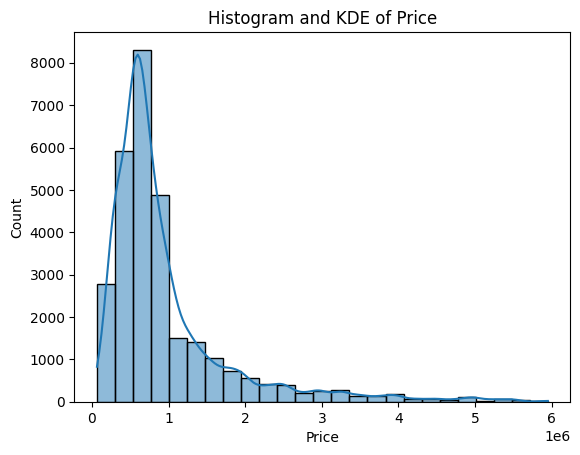

In [16]:
#========================================================================
# Step 2: Response

sns.histplot(df, x='Price', bins=25, kde=True)
plt.title('Histogram and KDE of Price', loc='center')

plt.show()

In [11]:
df

,Price,Property Type,Bedrooms,Bathrooms,Size,Postcode,Area,Price_Category,Area_Avg_Price
0,330000.0,Apartment,1.0,1.0,518.0,E14,Eastern,Low,1.001684e+06
1,340000.0,Flat,1.0,1.0,1.0,E14,Eastern,Low,1.001684e+06
2,340000.0,Apartment,1.0,1.0,2.0,E14,Eastern,Low,1.001684e+06
3,340000.0,Flat,1.0,1.0,1.0,E14,Eastern,Low,1.001684e+06
4,340000.0,Flat,1.0,1.0,388.0,SW20,South Western,Low,1.516724e+06
...,...,...,...,...,...,...,...,...,...
29532,795000.0,Flat,3.0,2.0,840.0,SW20,South Western,Medium,1.516724e+06
29533,795000.0,Flat,2.0,1.0,1.0,E14,Eastern,Medium,1.001684e+06
29534,795000.0,Flat,2.0,2.0,753.0,SE1,South Eastern,Medium,6.921048e+05
29535,795000.0,Flat,2.0,2.0,980.0,SW11,South Western,Medium,1.516724e+06
